<a href="https://colab.research.google.com/github/LNshuti/eactrade/blob/main/ec_trade_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install networkx --quiet
!pip install python-louvain --quiet
!pip install scipy --quiet

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
import seaborn as sns
import scipy

# Load your data. Load the parquet file
df = pd.read_parquet('processed\country_partner_sitcproduct4digit_year_2021.parquet')

# Filter df to only include location_code for East African countries
east_africa = ['BDI', 'KEN', 'RWA', 'TZA', 'UGA', 'ZMB', 'ZWE']
df = df[df['location_code'].isin(east_africa)]
df

,location_id,partner_id,product_id,year,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
7,17,7,669,2021.0,0.0,115706.0,-0.414691,-0.757308,BDI,ARE,0224
59,116,7,669,2021.0,0.0,4911402.0,-0.352045,0.878633,KEN,ARE,0224
91,187,7,669,2021.0,3869.0,449039.0,-0.480913,-0.076801,RWA,ARE,0224
110,226,7,669,2021.0,0.0,4509144.0,-0.914108,0.376584,TZA,ARE,0224
111,227,7,669,2021.0,253503.0,170044.0,-0.530818,-0.240852,UGA,ARE,0224
...,...,...,...,...,...,...,...,...,...,...,...
4173592,248,246,830,2021.0,0.0,50921.0,-1.006629,-1.051552,ZWE,ZAF,2784
4173653,226,46,830,2021.0,2128.0,0.0,-0.914108,0.376584,TZA,COD,2784
4173655,248,209,830,2021.0,0.0,85676.0,-1.006629,-1.051552,ZWE,SWZ,2784
4173658,17,226,830,2021.0,0.0,17977.0,-0.414691,-0.757308,BDI,TZA,2784


In [3]:
df.columns

Index(['location_id', 'partner_id', 'product_id', 'year', 'export_value',
       'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code'],
      dtype='object')

In [4]:
# Calculate total imports for each location
node_sizes = df.groupby(['product_id', 'location_code', 'partner_code'])['import_value'].sum().to_dict()
# Filter nodes to only include those with > 0
node_sizes = {k: v for k, v in node_sizes.items() if v > 200009683}
node_sizes

{(839, 'ZMB', 'COD'): 440177984.0,
 (866, 'KEN', 'ARE'): 716822528.0,
 (866, 'KEN', 'IND'): 406544256.0,
 (866, 'KEN', 'NLD'): 350202304.0,
 (866, 'KEN', 'SAU'): 740095680.0,
 (866, 'TZA', 'ARE'): 529486688.0,
 (866, 'TZA', 'IND'): 290552768.0,
 (866, 'TZA', 'SAU'): 692594240.0,
 (866, 'ZMB', 'SYC'): 274150880.0,
 (866, 'ZWE', 'SGP'): 326084480.0,
 (889, 'KEN', 'IDN'): 366200192.0,
 (889, 'KEN', 'MYS'): 727857024.0,
 (889, 'TZA', 'IDN'): 241752432.0,
 (944, 'KEN', 'IND'): 249736768.0,
 (944, 'TZA', 'IND'): 220872800.0,
 (1123, 'KEN', 'CHN'): 300414560.0,
 (1123, 'KEN', 'JPN'): 248592448.0,
 (1145, 'TZA', 'COD'): 570634432.0,
 (1145, 'ZMB', 'NAM'): 630898624.0,
 (1286, 'KEN', 'ARE'): 282559040.0,
 (1314, 'KEN', 'JPN'): 398094144.0,
 (1378, 'TZA', 'CHN'): 215874000.0,
 (1432, 'UGA', 'RUS'): 317547584.0,
 (1437, 'RWA', 'ANS'): 1084073728.0,
 (1437, 'ZWE', 'ANS'): 1444148224.0}

In [5]:
# Calculate total imports for each name and partner, and keep top 10
top_10_imports = df.groupby(['product_id', 'partner_code'])['import_value'].sum().nlargest(10).to_dict()
top_10_imports

{(1437, 'ANS'): 2720906816.0,
 (866, 'SAU'): 1514442865.0,
 (866, 'ARE'): 1334762964.0,
 (889, 'MYS'): 919361325.0,
 (944, 'IND'): 862091448.0,
 (866, 'IND'): 710381560.0,
 (1145, 'COD'): 705406560.0,
 (1314, 'JPN'): 681511313.0,
 (1145, 'NAM'): 630898624.0,
 (889, 'IDN'): 629316202.0}

In [6]:
# Create a directed graph, filtering for top 10
G = nx.from_pandas_edgelist(df[df.apply(lambda row: (row['product_id'], row['partner_code']) in top_10_imports, axis=1)],
                           'product_id', 'partner_code', edge_attr='import_value', create_using=nx.DiGraph())
G.nodes()

NodeView((866, 'ARE', 'IND', 'SAU', 889, 'IDN', 'MYS', 944, 1314, 'JPN', 1145, 'COD', 'NAM', 1437, 'ANS'))

In [7]:
G.edges()

OutEdgeView([(866, 'ARE'), (866, 'IND'), (866, 'SAU'), (889, 'IDN'), (889, 'MYS'), (944, 'IND'), (1314, 'JPN'), (1145, 'COD'), (1145, 'NAM'), (1437, 'ANS')])

In [8]:
def load_data(file_path):
    """
    Load the dataset from a parquet file.

    Args:
    file_path (str): The path to the parquet file.

    Returns:
    pd.DataFrame: The loaded dataframe.
    """
    return pd.read_parquet(file_path)

def format_currency(x, pos):
    """
    Format the value as currency with commas and a dollar sign.

    Args:
    x (float): The value to format.
    pos (int): Position index (required for the formatter but not used here).

    Returns:
    str: The formatted string.
    """
    return f"${x:,.0f}"

def filter_data(df):
    """
    Filter the necessary columns from the dataframe.

    Args:
    df (pd.DataFrame): The input dataframe.

    Returns:
    pd.DataFrame: The filtered dataframe.
    """
    return df[['product_id', 'export_value', 'import_value', 'year',
               'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
               'sitc_product_code']]

def create_network_graph(df):
    """
    Create a directed network graph from the dataframe.

    Args:
    df (pd.DataFrame): The filtered dataframe.

    Returns:
    nx.DiGraph: The created network graph.
    """
    G = nx.DiGraph()

    for index, row in df.iterrows():
        product = row['product_id']
        partner_id = row['partner_code']
        import_value = row['import_value']

        # Add nodes and weighted edges
        G.add_node(product)
        G.add_node(partner_id)
        G.add_edge(product, partner_id, weight=import_value, label='imports')

    return G


def plot_network_graph(G, partition=None):
    """
    Plot the network graph.

    Args:
    G (nx.DiGraph): The network graph to be plotted.
    partition (dict, optional): The partition of the graph for community detection.
    """
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 12))

    if partition:
        colors = [partition[node] for node in G.nodes()]
        nx.draw_networkx_nodes(G, pos, node_size=7000, node_color=colors, cmap=plt.cm.rainbow)
    else:
        nx.draw_networkx_nodes(G, pos, node_size=7000)

    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

    edge_labels = {(u, v): f"{d['label']} ({d['weight']})" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    plt.title("Comprehensive Network Analysis")
    plt.show()

def calculate_network_statistics(G):
    """
    Calculate and return network statistics.

    Args:
    G (nx.DiGraph): The network graph.

    Returns:
    dict: A dictionary containing network statistics.
    """
    stats = {
        'number_of_nodes': G.number_of_nodes(),
        'number_of_edges': G.number_of_edges(),
        'average_clustering': nx.average_clustering(G),
        'average_shortest_path_length': nx.average_shortest_path_length(G) if nx.is_connected(G.to_undirected()) else 'Graph is not connected',
        'density': nx.density(G)
    }
    return stats

def detect_communities(G):
    """
    Detect communities in the network graph using the Louvain method.

    Args:
    G (nx.DiGraph): The network graph.

    Returns:
    dict: A dictionary with nodes as keys and communities as values.
    """
    partition = community_louvain.best_partition(G.to_undirected())
    return partition

def plot_import_heatmap(df):
    """
    Plots a heatmap of import_value.

    Args:
        df (pd.DataFrame): The filtered dataframe.
    """
    import_matrix = df.pivot(index="product_id", columns="partner_code", values="import_value") # Updated pivot method syntax
    plt.figure(figsize=(14, 10))
    sns.heatmap(import_matrix, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title("Rwanda's Largest Imports by Partners in 2021")
    plt.xlabel("Partner Code")
    plt.ylabel("Product ID")

    plt.show()

In [9]:
df_filtered = filter_data(df)
df_filtered

,product_id,export_value,import_value,year,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
7,669,0.0,115706.0,2021.0,-0.414691,-0.757308,BDI,ARE,0224
59,669,0.0,4911402.0,2021.0,-0.352045,0.878633,KEN,ARE,0224
91,669,3869.0,449039.0,2021.0,-0.480913,-0.076801,RWA,ARE,0224
110,669,0.0,4509144.0,2021.0,-0.914108,0.376584,TZA,ARE,0224
111,669,253503.0,170044.0,2021.0,-0.530818,-0.240852,UGA,ARE,0224
...,...,...,...,...,...,...,...,...,...
4173592,830,0.0,50921.0,2021.0,-1.006629,-1.051552,ZWE,ZAF,2784
4173653,830,2128.0,0.0,2021.0,-0.914108,0.376584,TZA,COD,2784
4173655,830,0.0,85676.0,2021.0,-1.006629,-1.051552,ZWE,SWZ,2784
4173658,830,0.0,17977.0,2021.0,-0.414691,-0.757308,BDI,TZA,2784


In [10]:
# Filter out rows where both imports and exports are equal to zero
df_filtered = df_filtered[(df_filtered['import_value'] != 0) | (df_filtered['export_value'] != 0)]
df_filtered

,product_id,export_value,import_value,year,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
7,669,0.0,115706.0,2021.0,-0.414691,-0.757308,BDI,ARE,0224
59,669,0.0,4911402.0,2021.0,-0.352045,0.878633,KEN,ARE,0224
91,669,3869.0,449039.0,2021.0,-0.480913,-0.076801,RWA,ARE,0224
110,669,0.0,4509144.0,2021.0,-0.914108,0.376584,TZA,ARE,0224
111,669,253503.0,170044.0,2021.0,-0.530818,-0.240852,UGA,ARE,0224
...,...,...,...,...,...,...,...,...,...
4173592,830,0.0,50921.0,2021.0,-1.006629,-1.051552,ZWE,ZAF,2784
4173653,830,2128.0,0.0,2021.0,-0.914108,0.376584,TZA,COD,2784
4173655,830,0.0,85676.0,2021.0,-1.006629,-1.051552,ZWE,SWZ,2784
4173658,830,0.0,17977.0,2021.0,-0.414691,-0.757308,BDI,TZA,2784


In [11]:
# Filter out rows where (if imports are equal to zero and exports less than 30000
# Or exports equal to zero and imorts less than 30000)
df_filtered = df_filtered[~(((df_filtered['import_value'] == 0) & (df_filtered['export_value'] < 180000000)) |
                           ((df_filtered['export_value'] == 0) & (df_filtered['import_value'] < 180000000)))]

df_filtered

,product_id,export_value,import_value,year,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
91,669,3.869000e+03,4.490390e+05,2021.0,-0.480913,-0.076801,RWA,ARE,0224
111,669,2.535030e+05,1.700440e+05,2021.0,-0.530818,-0.240852,UGA,ARE,0224
670,669,1.279000e+03,3.616000e+03,2021.0,-0.352045,0.878633,KEN,CHN,0224
1883,669,3.353620e+05,2.682100e+04,2021.0,-0.352045,0.878633,KEN,IND,0224
3944,669,1.856400e+04,3.298000e+03,2021.0,-0.480913,-0.076801,RWA,ZAF,0224
...,...,...,...,...,...,...,...,...,...
4169471,840,4.898088e+08,1.853000e+03,2021.0,-1.006629,-1.051552,ZWE,ZAF,2872
4169494,840,1.779000e+03,2.150000e+03,2021.0,-0.840217,-0.882403,ZMB,AUS,2872
4172584,1437,0.000000e+00,1.926849e+08,2021.0,-0.414691,-0.757308,BDI,ANS,ZZZZ
4172655,1437,4.420524e+08,1.084074e+09,2021.0,-0.480913,-0.076801,RWA,ANS,ZZZZ


In [12]:
# Only keep Rwanda's data
df_filtered = df_filtered[df_filtered['location_code'] == 'RWA']
df_filtered

,product_id,export_value,import_value,year,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
91,669,3869.0,4.490390e+05,2021.0,-0.480913,-0.076801,RWA,ARE,0224
3944,669,18564.0,3.298000e+03,2021.0,-0.480913,-0.076801,RWA,ZAF,0224
6161,669,6172.0,1.179000e+03,2021.0,-0.480913,-0.076801,RWA,ZMB,0224
6982,732,732930.0,3.063400e+04,2021.0,-0.480913,-0.076801,RWA,ARE,0741
7647,732,3381054.0,6.839000e+03,2021.0,-0.480913,-0.076801,RWA,CHN,0741
...,...,...,...,...,...,...,...,...,...
4073497,786,2787.0,1.442000e+03,2021.0,-0.480913,-0.076801,RWA,IND,2511
4074826,786,1830.0,1.001990e+05,2021.0,-0.480913,-0.076801,RWA,KEN,2511
4075390,786,8934.0,1.719600e+04,2021.0,-0.480913,-0.076801,RWA,TZA,2511
4118228,763,38097.0,6.509100e+04,2021.0,-0.480913,-0.076801,RWA,KEN,2222


In [13]:
G = create_network_graph(df_filtered)
G.nodes()

NodeView((669, 'ARE', 'ZAF', 'ZMB', 732, 'CHN', 'IND', 'KEN', 'TZA', 743, 'BEL', 'GBR', 'USA', 'NGA', 'COD', 748, 'DEU', 753, 754, 948, 950, 968, 992, 'THA', 1032, 'NLD', 1112, 1160, 1169, 'GHA', 1180, 1181, 'BDI', 1182, 1193, 1198, 1261, 1273, 'CHE', 'FIN', 'IRL', 'ITA', 1277, 1286, 'AUT', 'FRA', 'ETH', 1291, 'ESP', 'HKG', 1294, 1299, 1307, 'MYS', 1321, 1373, 1408, 'SWE', 'EGY', 'MAR', 'UGA', 'VNM', 1432, 668, 670, 680, 685, 687, 690, 693, 696, 697, 698, 699, 701, 702, 703, 704, 705, 706, 714, 717, 719, 'CAN', 725, 726, 727, 731, 734, 735, 740, 745, 746, 747, 815, 'KOR', 833, 837, 854, 855, 858, 866, 'TUR', 'QAT', 872, 889, 'MWI', 893, 905, 926, 936, 939, 944, 946, 949, 951, 955, 959, 961, 976, 983, 986, 987, 1004, 1006, 1009, 1012, 1022, 1033, 1035, 1036, 1047, 1048, 1050, 1068, 1075, 1077, 1078, 1088, 1109, 1111, 1113, 1125, 1146, 1162, 1163, 1167, 1170, 1171, 1173, 1174, 1176, 1179, 1189, 1190, 1197, 1210, 1211, 1214, 1225, 1227, 1228, 1229, 1230, 1236, 1238, 1241, 1244, 'POL', 124

In [14]:
# Display the 10 most prominent edges
G.edges(data=True)

OutEdgeDataView([(669, 'ARE', {'weight': 449039.0, 'label': 'imports'}), (669, 'ZAF', {'weight': 3298.0, 'label': 'imports'}), (669, 'ZMB', {'weight': 1179.0, 'label': 'imports'}), (732, 'ARE', {'weight': 30634.0, 'label': 'imports'}), (732, 'CHN', {'weight': 6839.0, 'label': 'imports'}), (732, 'IND', {'weight': 1806.0, 'label': 'imports'}), (732, 'KEN', {'weight': 8963.0, 'label': 'imports'}), (732, 'TZA', {'weight': 59158.0, 'label': 'imports'}), (743, 'BEL', {'weight': 1843278.0, 'label': 'imports'}), (743, 'GBR', {'weight': 12650.0, 'label': 'imports'}), (743, 'USA', {'weight': 1214898.0, 'label': 'imports'}), (743, 'KEN', {'weight': 5524622.0, 'label': 'imports'}), (743, 'NGA', {'weight': 19775.0, 'label': 'imports'}), (743, 'COD', {'weight': 19000.0, 'label': 'imports'}), (743, 'TZA', {'weight': 1244323.0, 'label': 'imports'}), (748, 'ARE', {'weight': 400060.0, 'label': 'imports'}), (748, 'DEU', {'weight': 60254.0, 'label': 'imports'}), (748, 'USA', {'weight': 82021.0, 'label': '

In [15]:
#plot_network_graph(G)

In [16]:
partition = detect_communities(G)
#partition

In [17]:
#plot_network_graph(G, partition)

In [18]:
# Check for duplicates in the 'name' column
print(df_filtered['product_id'].duplicated().sum())

# 1. Drop duplicates:
df_filtered = df_filtered.drop_duplicates(subset=['product_id'])
df_filtered

424


,product_id,export_value,import_value,year,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
91,669,3869.0,4.490390e+05,2021.0,-0.480913,-0.076801,RWA,ARE,0224
6982,732,732930.0,3.063400e+04,2021.0,-0.480913,-0.076801,RWA,ARE,0741
14235,743,2527.0,1.843278e+06,2021.0,-0.480913,-0.076801,RWA,BEL,0980
28780,748,198751.0,4.000600e+05,2021.0,-0.480913,-0.076801,RWA,ARE,1124
38000,753,32663.0,3.782200e+04,2021.0,-0.480913,-0.076801,RWA,ARE,1222
...,...,...,...,...,...,...,...,...,...
3957897,952,114345.0,4.334400e+04,2021.0,-0.480913,-0.076801,RWA,USA,5621
4050040,678,136259.0,2.228500e+04,2021.0,-0.480913,-0.076801,RWA,COD,0350
4073497,786,2787.0,1.442000e+03,2021.0,-0.480913,-0.076801,RWA,IND,2511
4118228,763,38097.0,6.509100e+04,2021.0,-0.480913,-0.076801,RWA,KEN,2222


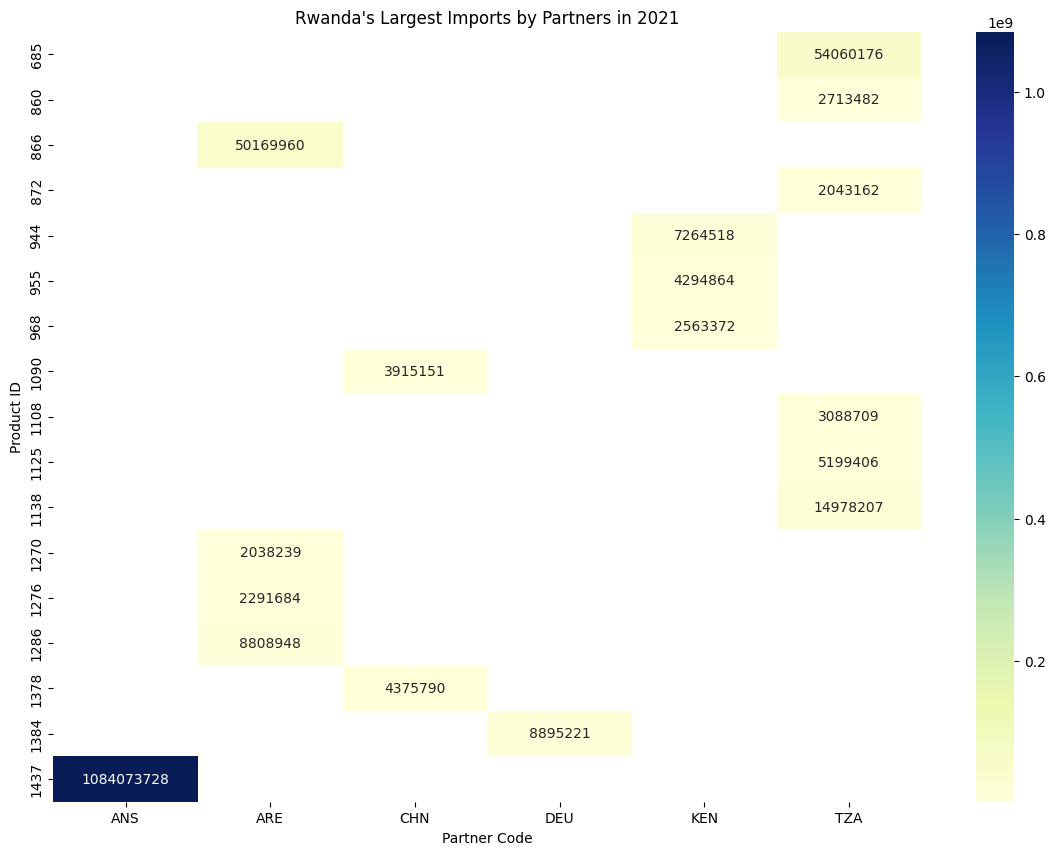

In [19]:
# 2. Aggregate duplicates (e.g., sum imports for the same name):
df_filtered = df_filtered.groupby('product_id').agg({'partner_code': 'first', 'import_value': 'sum'}).reset_index()

# Only keep imports greater than 2000000
df_filtered = df_filtered[df_filtered['import_value'] > 2000000]
plot_import_heatmap(df_filtered)

In [20]:
network_stats = calculate_network_statistics(G)
network_stats

{'number_of_nodes': 299,
 'number_of_edges': 677,
 'average_clustering': 0.0,
 'average_shortest_path_length': 'Graph is not connected',
 'density': 0.007598033714170276}

### Community Detection using the Louvain Algorithm 

#### Introduction
The Louvain algorithm is a method for detecting communities in large networks. It is a hierarchical algorithm that optimizes the modularity of the partitions. We apply the Louvain algorithm using the `python-louvain` package on the dataset explored previously focusing on Rwanda's trade relationships.

#### Dataset
The dataset includes the following features:
- `product_id`: Product Id
- `import_value`: Import values
- `export_value`: Export values
- `partner_code`: Identifier for trading partners
- `year`: Year of the data

In [21]:
G_undirected = G.to_undirected()
# Apply the Louvain algorithm
partition = community_louvain.best_partition(G_undirected)

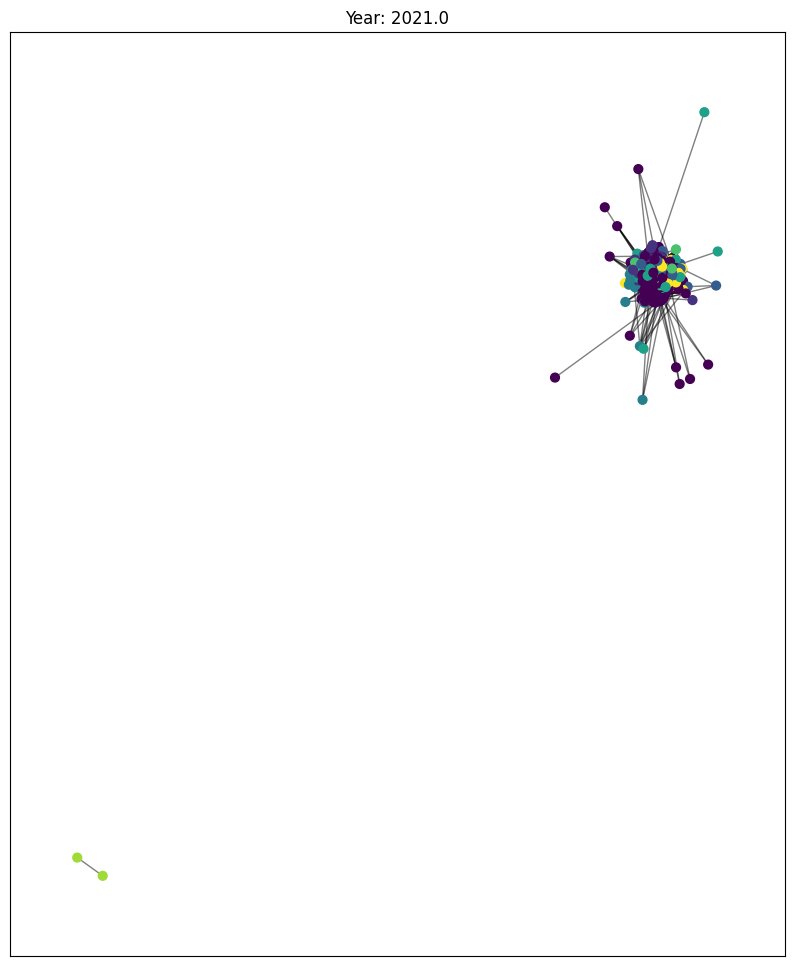

In [23]:
# Function to create a graph for a specific year
def create_year_graph(year):
    G_year = nx.Graph()
    year_data = df[df['year'] == year]
    for _, row in year_data.iterrows():
        G_year.add_node(row['product_id'])
        G_year.add_edge(row['product_id'], row['partner_code'], weight=row['import_value'] + row['export_value'])
    return G_year
# Visualize the network dynamics over the years
years = sorted(df['year'].unique())
for year in years:
    G_year = create_year_graph(year)
    partition = community_louvain.best_partition(G_year)
    pos = nx.spring_layout(G_year)
    plt.figure(figsize=(10, 12))  # Adjust the size as needed

    cmap = plt.get_cmap('viridis', max(partition.values()) + 1)
    nx.draw_networkx_nodes(G_year, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G_year, pos, alpha=0.5)
    plt.title(f'Year: {year}')
    plt.show()